In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import numpy as np
import sys
import os

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath('../../'))

import utils.ml_util
importlib.reload(utils.ml_util)
from utils.ml_util import *

import utils.trading_util
importlib.reload(utils.trading_util)
from utils.trading_util import *

2025-01-14 22:32:29.020523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736911949.039047   12230 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736911949.044404   12230 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 22:32:29.064008: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[*********************100%***********************]  1 of 1 completed


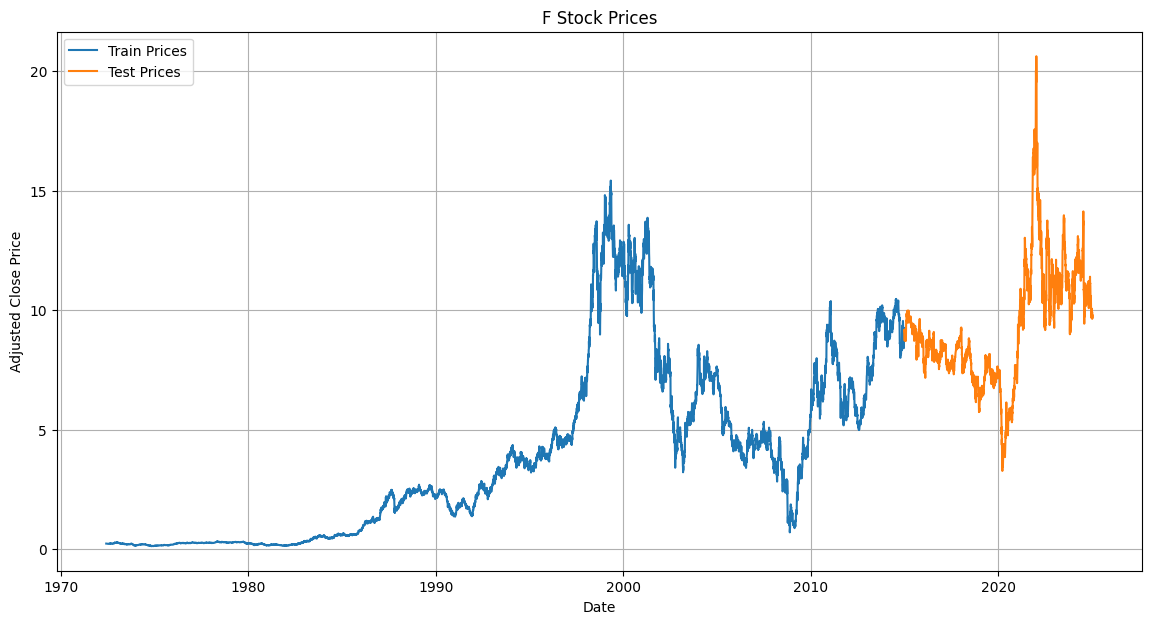

In [2]:
TKR = 'F'
MAX_HOLDING = 100
MAX_HISTORY = 200
FEATURE_KERNEL_SIZES = [5, 10]
TEST_TRAIN_SPLIT = pd.Timestamp('2015-01-01')
TIME_EFFECT = 2

historic_prices = yf.download(TKR)['Close']
train_prices, test_prices = historic_prices[TKR][:TEST_TRAIN_SPLIT].to_list(), historic_prices[TKR][TEST_TRAIN_SPLIT:].to_list()
plt.figure(figsize=(14, 7))
plt.plot(historic_prices[TKR][:TEST_TRAIN_SPLIT], label='Train Prices')
plt.plot(historic_prices[TKR][TEST_TRAIN_SPLIT:], label='Test Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title(f'{TKR} Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
outlook = []
for pos1 in range(len(train_prices) - MAX_HOLDING):
    ans = 0
    for pos2 in range(1, MAX_HOLDING):
        ans += (train_prices[pos1 + pos2] - train_prices[pos1]) * time_effect[TIME_EFFECT](MAX_HOLDING, pos2)
    outlook.append(ans / time_effect_integrals[TIME_EFFECT](MAX_HOLDING))
    
n_outlook = normalize_average(outlook, MAX_HOLDING * 3)

In [4]:
features = get_sma_sd_v(train_prices, FEATURE_KERNEL_SIZES, MAX_HISTORY)[:-MAX_HOLDING - 1]
n_outlook = n_outlook[MAX_HISTORY + max(FEATURE_KERNEL_SIZES) - 1:]

x = np.array(features)
x_copy = np.copy(x)
y = np.array(n_outlook)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

def create_model():
    inputs = tf.keras.layers.Input(shape=(len(x_train[0]), 1))
    
    x = tf.keras.layers.Dense(512, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    outputs = tf.keras.layers.Dense(1, activation='tanh')(x)
    
    return tf.keras.models.Model(inputs, outputs)

def custom_weighted_loss(y_true, y_pred):
    error = y_true - y_pred
    weight = tf.square(y_true)
    loss = tf.reduce_mean(weight * tf.square(error))
    return loss

model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=custom_weighted_loss)
print(model.summary())


I0000 00:00:1736911957.656517   12230 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4622 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
W0000 00:00:1736911958.032603   12331 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/krish-modi/anaconda3/envs/quant/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/krish-modi/anaconda3/envs/quant/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/krish-modi/anaconda3/envs/quant/lib/python3.10/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search 

KeyboardInterrupt: 

In [6]:
model.fit(x=x_train, 
        y=y_train, 
        epochs=30, 
        validation_data=(x_test, y_test), 
    )

Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - loss: 0.1336 - val_loss: 0.0936
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - loss: 0.0937 - val_loss: 0.0930
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - loss: 0.0950 - val_loss: 0.0930
Epoch 4/30
123/261 ━━━━━━━━━━━━━━━━━━━━ 2:24 1s/step - loss: 0.0913

KeyboardInterrupt: 

In [7]:
features = get_sma_sd_v(test_prices, FEATURE_KERNEL_SIZES, MAX_HISTORY)
test_prices = test_prices[MAX_HISTORY + max(FEATURE_KERNEL_SIZES) - 1:]

x = np.array(features)

p_outlook = model.predict(x)
p_outlook = [x[0] for x in p_outlook]

73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 563ms/step


In [8]:
test_o = []
for pos1 in range(len(test_prices) - MAX_HOLDING):
    ans = 0
    for pos2 in range(1, MAX_HOLDING):
        ans += (test_prices[pos1 + pos2] - test_prices[pos1]) * time_effect[TIME_EFFECT](MAX_HOLDING, pos2)
    test_o.append(ans / time_effect_integrals[TIME_EFFECT](MAX_HOLDING))

test_on = normalize_average(test_o, MAX_HOLDING * 3)

err_test = [test_on[pos] - p_outlook[pos] for pos in range(len(test_on))]
train_outlook_p = model.predict(x_copy)
err_train = [train_outlook_p[pos] - y[pos] for pos in range(len(train_outlook_p))]


188/188 ━━━━━━━━━━━━━━━━━━━━ 98s 520ms/step


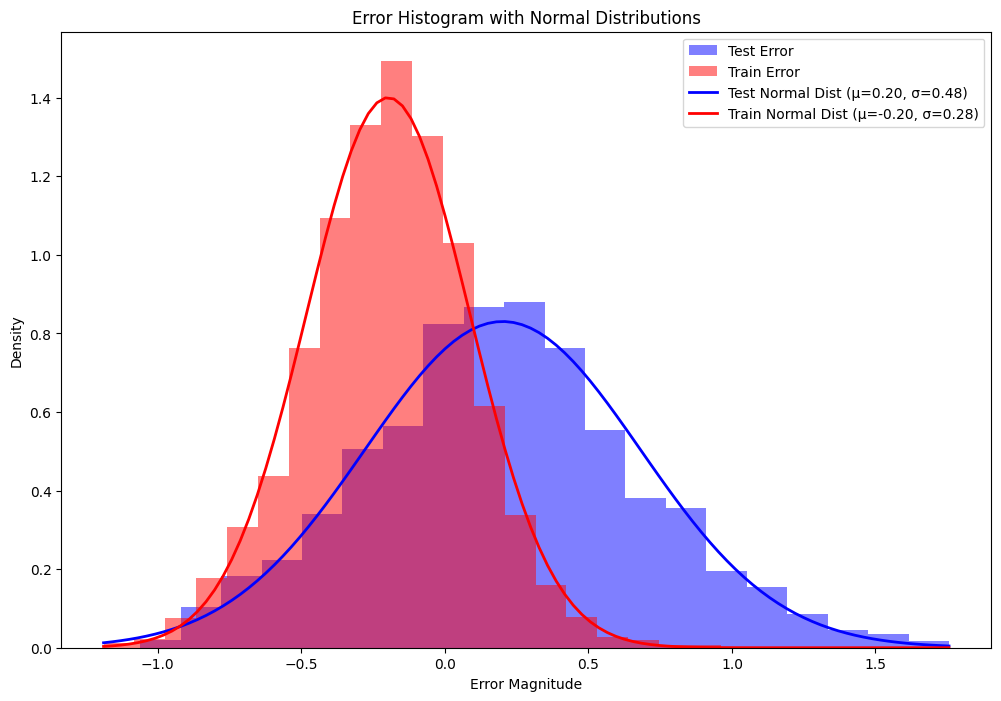

In [9]:
err_test = np.array(err_test)
err_train = np.array(err_train)

mu_test = np.mean(err_test)
std_test = np.std(err_test)
mu_train = np.mean(err_train)
std_train = np.std(err_train)

x = np.linspace(min(err_test.min(), err_train.min()), max(err_test.max(), err_train.max()), 100)
y_test = (1 / (std_test * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu_test) / std_test)**2)
y_train = (1 / (std_train * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu_train) / std_train)**2)

plt.figure(figsize=(12, 8))
plt.hist(err_test, bins=20, density=True, alpha=0.5, label='Test Error', color='blue')
plt.hist(err_train, bins=20, density=True, alpha=0.5, label='Train Error', color='red')

plt.plot(x, y_test, 'blue', lw=2, label=f'Test Normal Dist (μ={mu_test:.2f}, σ={std_test:.2f})')
plt.plot(x, y_train, 'red', lw=2, label=f'Train Normal Dist (μ={mu_train:.2f}, σ={std_train:.2f})')

plt.title('Error Histogram with Normal Distributions')
plt.xlabel('Error Magnitude')
plt.ylabel('Density')
plt.legend()
plt.show()